## SVD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import sklearn.decomposition
import sklearn.manifold

import time
from underrate import *

## load data

In [2]:
dRatings = loadRatings("data/data.txt")
dTrain = loadRatings("data/train.txt", dRatings.shape)
dTest = loadRatings("data/test.txt", dRatings.shape)

dUsers = pd.DataFrame(index=dRatings.index)
dMovies, dGenres = loadMovies("data/movies.txt")

nUsers = dUsers.shape[0]
nRatings = dRatings.shape[0]
nMovies = dMovies.shape[0]
nGenres = dGenres.shape[1]

In [3]:
stats = ratingStats(dRatings)
dMovies = pd.concat([dMovies, stats[1]], axis=1)
dUsers = pd.concat([dUsers, stats[0]], axis=1)

In [4]:
def errplot(E_in, E_out):
    plt.plot(Ks, E_in, label='$E_{in}$')
    plt.plot(Ks, E_out, label='$E_{out}$')
    plt.title('Error vs. K')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.legend()

In [5]:
# Selection of movies to plot projections of
choices = {
    "choice": dMovies.loc[dGenres["animation"]==1,:].sort_values("nratings").tail(10).index.values,
    "popular": dMovies.sort_values("nratings").tail(10).index.values,
    "highrated": dMovies.sort_values("movieavg").tail(10).index.values,

    "animation": dMovies.loc[dGenres["animation"]==1,:].tail(10).index.values,
    "thriller": dMovies.loc[dGenres["thriller"]==1,:].tail(10).index.values,
    "fantasy": dMovies.loc[dGenres["fantasy"]==1,:].tail(10).index.values
}

In [6]:
def plotproj(Vp, dMovies, choices, prefix=""):
    """"""
    print(Vp.shape)
    for choice,movies in choices.items():
        plt.figure(figsize=(6,4))
        plt.title(choice)
        plt.scatter(Vp[movies-1,0], Vp[movies-1,1])
        for i in movies:
            plt.annotate(dMovies.loc[i,"title"], Vp[i-1])
        plt.savefig(prefix+choice+".png", dpi=200)

## unbiased

In [7]:
def err_unbiased(ratings, U, V, reg=0.0, N=None):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = N if N else (~np.isnan(dRatings.values)).sum()
    r = .5 * reg / N * (np.sum(np.square(U)) + np.sum(np.square(V))) if reg else 0
    return np.nanmean(np.square(ratings.values - np.matmul(U, V.T)))

In [8]:
def train_unbiased(ratings, K, eta, reg, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSEs
    of the model.
    """
    n_users, n_movies = ratings.shape
    users_i, movies_i = (~np.isnan(ratings.values)).nonzero()
    n_ratings = len(users_i)
    ratings_ = ratings.values
    U = np.random.rand(n_users, K) - 0.5
    V = np.random.rand(n_movies, K) - 0.5
    eprev = err_unbiased(ratings, U, V)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(n_ratings):
            user, movie = users_i[i], movies_i[i]
            rating = ratings_[user, movie]
            Ui, Vj = U[user], V[movie]
            # calculate gradients at once
            err = rating - np.dot(Ui, Vj)
            gU = reg * Ui - Vj * err
            gV = reg * Vj - Ui * err
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
        e = err_unbiased(ratings, U, V)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, e

In [9]:
reg = 0.1
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
start = time.time()
unbiased = train_unbiased(dTrain, K, eta, reg)

ein = err_unbiased(dTrain, *unbiased)
eout = err_unbiased(dTest, *unbiased)
print("elapsed", time.time() - start)

print("Ein", ein, "Eout", eout)

epoch 0 13.853950131049189 12.846301667791103
epoch 1 1.0076484632580849 0.01116565813575388
epoch 2 0.8642110505267645 0.0026914224140457024
epoch 3 0.8296362262804788 0.002702790209014062
epoch 4 0.794915367910732 0.0018743123975198503
epoch 5 0.7708373854325112 0.002148356920232584
epoch 6 0.7432389443451168 0.002271881877288401
epoch 7 0.7140536643958825 0.00037593569387540764
epoch 8 0.7092242810646686 0.0007547662541428808
epoch 9 0.6995283260752805 0.002058867047949606
epoch 10 0.6730794988834453 0.00032508699639894863
epoch 11 0.6689033332594283 0.0010776035745902895
epoch 12 0.6550601126619514 0.0007345274312156073
epoch 13 0.645624151697288 0.0008888017877616885
epoch 14 0.6342063358088293 0.001099450976434883
epoch 15 0.6200824568965994 -0.00038628544694795276
trained epochs: 15 -0.004962339381370917
elapsed 24.100751161575317
Ein 0.6250447962779703 Eout 0.8925195172779326


In [10]:
svd_u = sklearn.decomposition.TruncatedSVD()
svd_u.fit(unbiased[1])
Up = svd_u.transform(unbiased[0])
Vp = svd_u.transform(unbiased[1])

(1682, 2)


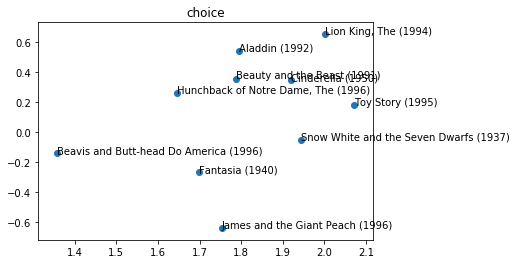

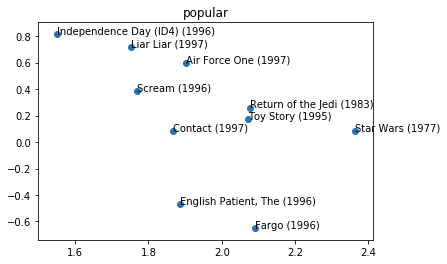

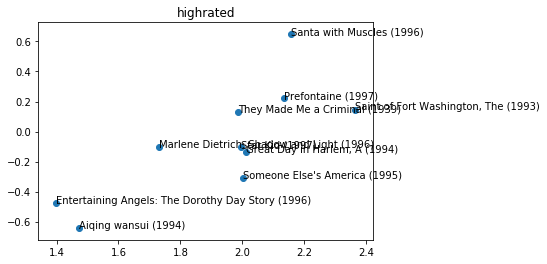

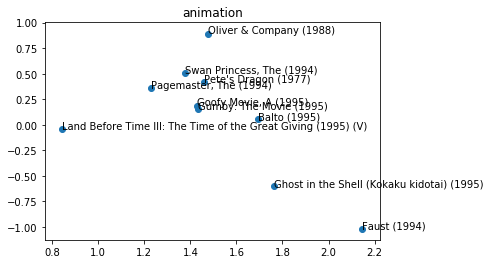

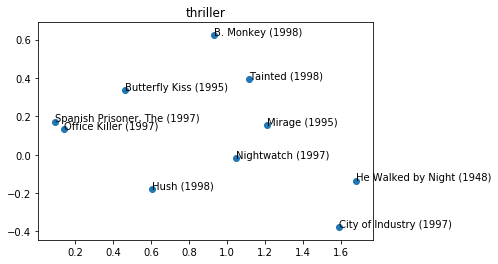

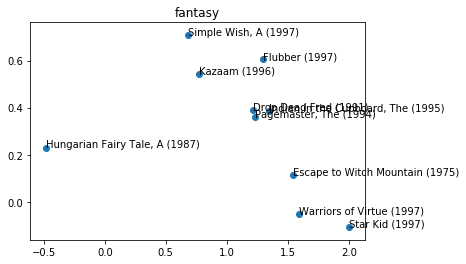

In [11]:
plotproj(Vp, dMovies, choices, "plots/ub_")

## biased

In [12]:
def err_biased(ratings, U, V, A, B, mu, reg=0.0, N=None):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = N if N else (~np.isnan(dRatings.values)).sum()
    r = .5 * reg / N * (np.sum(np.square(U)) + np.sum(np.square(V)) + np.sum(np.square(A)) + np.sum(np.square(B))) if reg else 0
    pred = mu + np.matmul(U, V.T) + np.reshape(A, (-1,1)) + B
    return np.nanmean(np.square(ratings.values - pred))

def train_biased(ratings, K, eta, reg, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSEs
    of the model.
    """
    n_users, n_movies = ratings.shape
    users_i, movies_i = (~np.isnan(ratings.values)).nonzero()
    mu = np.nanmean(ratings.values)
    n_ratings = len(users_i)
    ratings_ = ratings.values
    U = np.random.rand(n_users, K) - 0.5
    V = np.random.rand(n_movies, K) - 0.5
    A = ratings.mean(axis=1).values
    B = ratings.mean(axis=0).values
    eprev = err_biased(ratings, U, V, A, B, mu)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(n_ratings):
            user, movie = users_i[i], movies_i[i]
            rating = ratings_[user, movie]
            Ui, Vj, Ai, Bj = U[user], V[movie], A[user], B[movie]
            # calculate gradients at once
            err = rating - (mu + np.dot(Ui, Vj) + A[user] + B[movie])
            gU = reg * Ui - Vj * err
            gV = reg * Vj - Ui * err
            gA = reg * Ai - err
            gB = reg * Bj - err
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
            A[user] -= eta * gA
            B[movie] -= eta * gB
        e = err_biased(ratings, U, V, A, B, mu)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, A, B, mu

In [13]:
reg = 0.1
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
start = time.time()
biased = train_biased(dTrain, K, eta, reg)

ein = err_biased(dTrain, *biased)
eout = err_biased(dTest, *biased)
print("elapsed", time.time() - start)

print("Ein", ein, "Eout", eout)

epoch 0 50.84466687773015 49.656201177242906
epoch 1 1.1884657004872432 0.006156189916106028
epoch 2 0.8827726955277682 0.0015335334336363862
epoch 3 0.8066232508350917 0.0008414106484931783
epoch 4 0.76484199440084 0.0006445000217281587
epoch 5 0.7328385716631691 0.0005432199607365734
epoch 6 0.7058643320093398 0.0004994113253117226
epoch 7 0.6810654627694674 0.00035871770353406606
epoch 8 0.6632529043169413 0.00033292185014479654
epoch 9 0.6467212699498514 0.0002971225427916409
epoch 10 0.6319672931906957 0.00022916980592002778
epoch 11 0.620587591204181 0.0002109170445629281
epoch 12 0.6101142520076548 0.00023296531582905843
epoch 13 0.5985460794175271 0.00014530016461303935
epoch 14 0.5913310252124155 0.00016314462963502982
epoch 15 0.5832298826622717 0.00015751773835602793
epoch 16 0.5754081501574805 0.00011307197912776142
epoch 17 0.5697934252144033 7.645922204191776e-05
trained epochs: 17 0.0037966745115689537
elapsed 31.3769109249115
Ein 0.5659967507028344 Eout 0.86105686598680

In [14]:
svd_b = sklearn.decomposition.TruncatedSVD()
svd_b.fit(biased[1])
Upb = svd_b.transform(unbiased[0])
Vpb = svd_b.transform(unbiased[1])

(1682, 2)


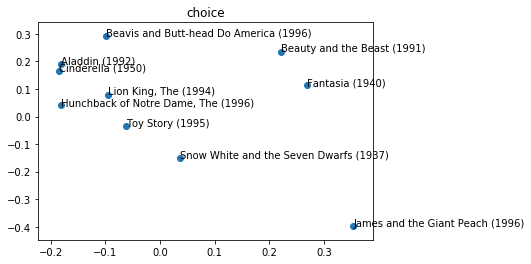

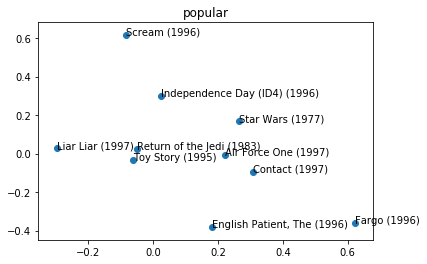

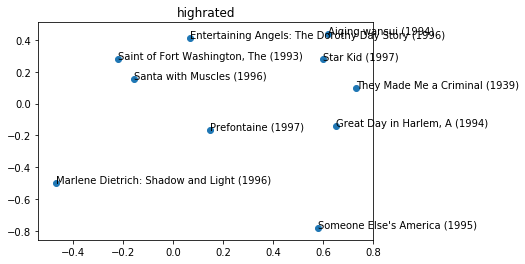

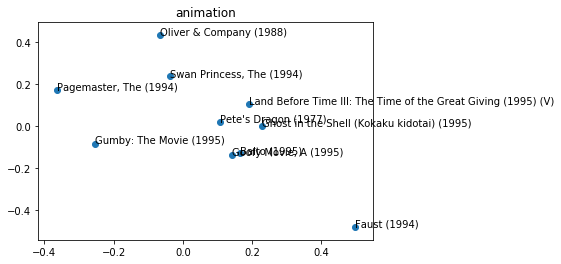

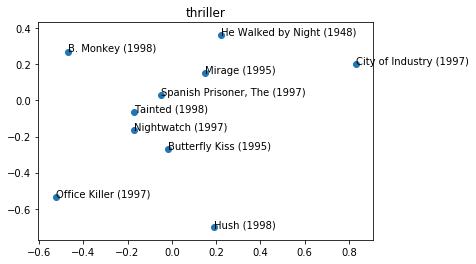

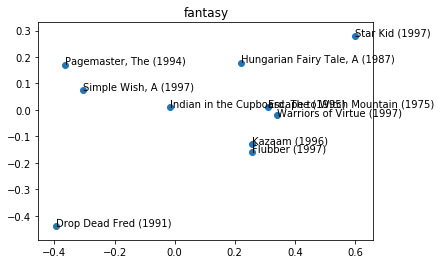

In [15]:
plotproj(Vpb, dMovies, choices, "plots/b_")

## experiment

In [16]:
tsneMovies = sklearn.manifold.TSNE(n_components=2).fit_transform(biased[1])
print(tsneMovies.shape)

(1682, 2)


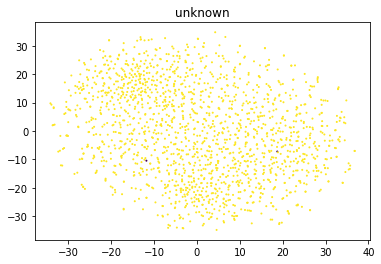

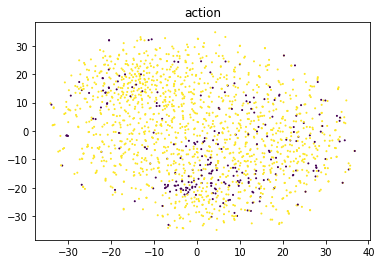

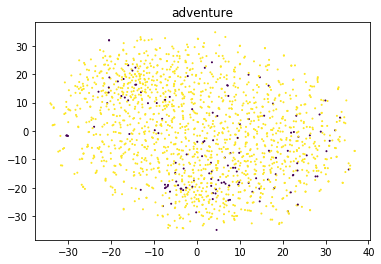

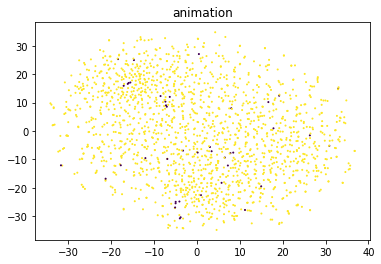

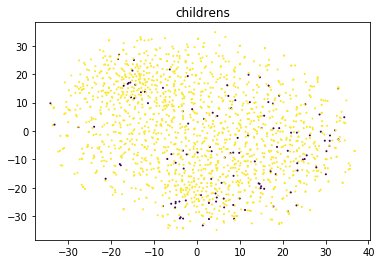

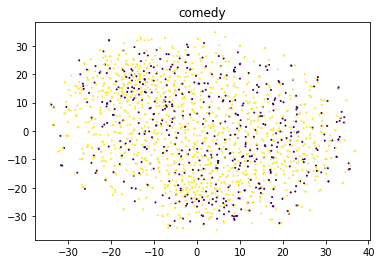

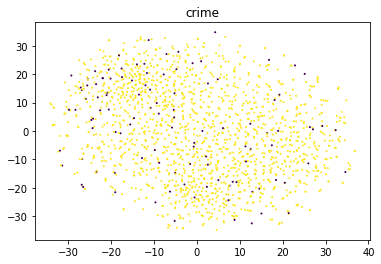

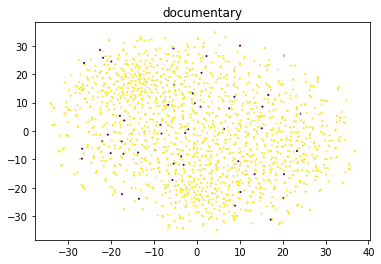

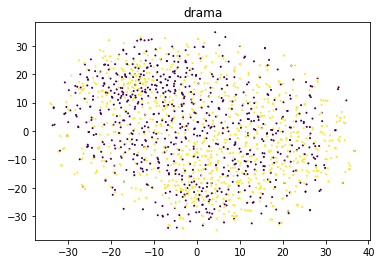

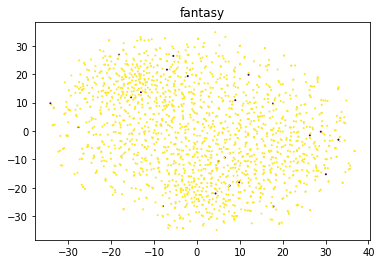

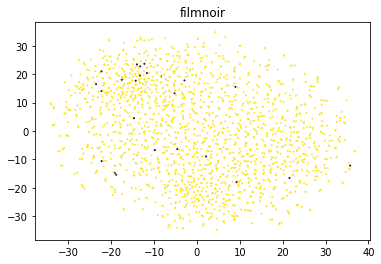

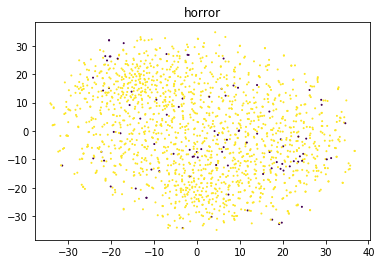

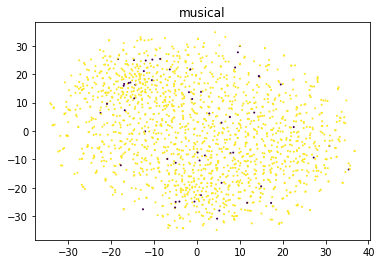

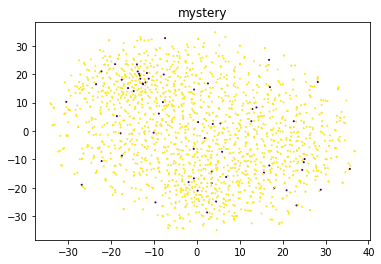

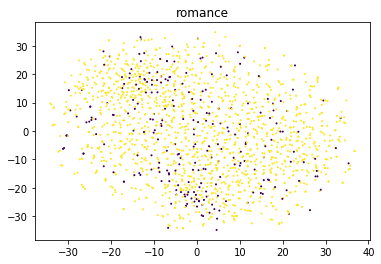

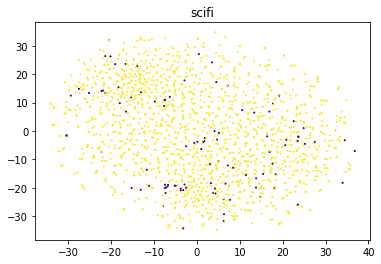

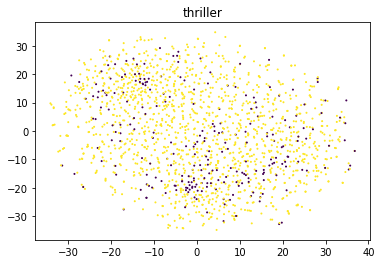

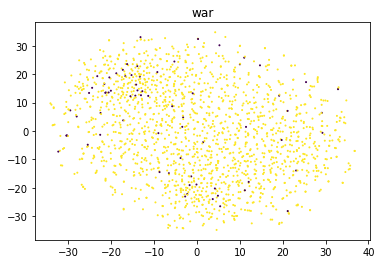

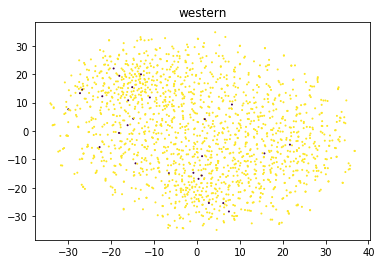

In [17]:
for i in range(19):
    plt.figure()
    plt.title(dGenres.columns[i])
    plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=-dGenres.iloc[:,i])

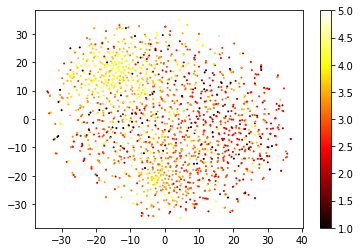

In [18]:
plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=dMovies["movieavg"], cmap="hot")
plt.colorbar()